#  **Machine Learning for Finance – Assignment I**

> Machine Learning for Finance – 2025

> VU Amsterdam    

> Authors: Siddharth Kukreja (2902483) & Milan Peter (2902483)

# **Case I: Predicting housing prices**

This case is about predicting housing prices of a fictive country, making use of several ML methods we have seen during the course. 
We assume that a company hired us as a data scientist and ask us the following questions:
- Should we model the housing price or the logarithm of the housing price?
- Given the previous question, which model should we then use to predict the housing price? As a benchmark, the company uses the multivariate linear regression model. 

In [209]:
# Importing libraries –––––
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Setting seed for reproducibility
random.seed(0)

## **Data and Preprocessing**

Each group has its own dataset, called `data_ASS_I_group_i`, where `i` is your group number. Download this from Canvas. Apart from the variables Price (in dollars), No. of Bedrooms and Area (sq ft), all the variables are dummy variables.
Inspect the data and pay attention to the following
- Missing values: Are there any missing or peculiar values? If so, treat them adequately with explanation
- Make a histogram of the housing price and the natural logarithm (log) of the housing price and test on normality
- Create **Table 1** with summary statistics of the housing price, Area and 1 randomly selected features. Interpret the mean of all variables.  


Our group number is 25. First, we inspect the data.

In [210]:
# Data and Preprocessing –––––

# Read data
df = pd.read_excel('data_ASS_I_group_25.xlsx', sheet_name='Data')

print(f"Original: {len(df)} rows")
print(df.describe())

# Remove rows with 9 in any column
df = df[(df != 9).all(axis=1)].reset_index(drop=True)

print(f"\nAfter removing 9s: {len(df)} rows")
print(df.describe())

# Looking at price outliers
print(df.nlargest(5, 'Price'))

# Remove the most expensive house
df = df[df['Price'] != df['Price'].max()].reset_index(drop=True)


Original: 2053 rows
              Price         Area  No. of Bedrooms       Resale  \
count  2.053000e+03  2053.000000      2053.000000  2053.000000   
mean   9.863945e+06  1643.753531         2.619094     0.224062   
std    9.078333e+06   755.962188         0.685456     0.417065   
min    2.000000e+06   500.000000         1.000000     0.000000   
25%    4.748000e+06  1155.000000         2.000000     0.000000   
50%    7.800000e+06  1490.000000         3.000000     0.000000   
75%    1.090000e+07  1820.000000         3.000000     0.000000   
max    1.650000e+08  9400.000000         8.000000     1.000000   

       MaintenanceStaff    Gymnasium  SwimmingPool  LandscapedGardens  \
count       2053.000000  2053.000000   2053.000000         2053.00000   
mean           0.396980     0.729664      0.699951            0.60643   
std            1.587515     1.574183      1.578234            1.58729   
min            0.000000     0.000000      0.000000            0.00000   
25%            0.000

In the dataset, there are no missing values. There are however dummy variables with all values set to 9 which have been removed from the dataset. The most expensive house was sold for twice the price of the second most expensive, appears to be significantly smaller and with less bedrooms. This suggests that it might be a typographical error, and while it isn't outside the realm of possibility it's better to remove such an extreme outlier for the purpose of the model. 

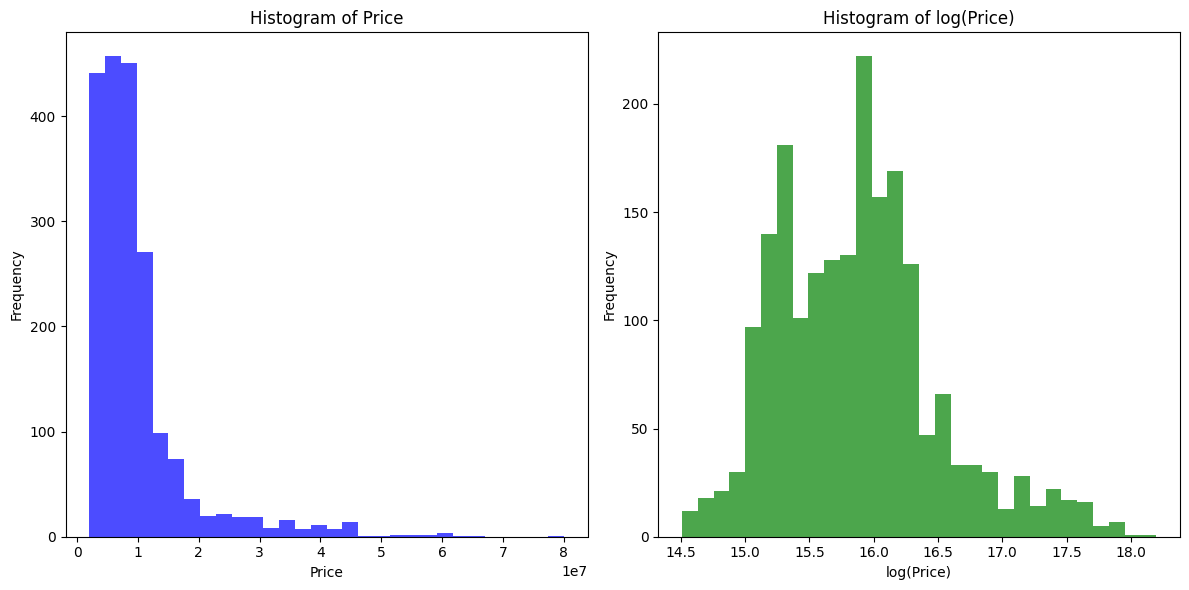

Shapiro-Wilk Test for Price: Statistics=0.672, p=0.000
Shapiro-Wilk Test for log(Price): Statistics=0.966, p=0.000


In [211]:
# Histograms and Normality tests

# Histogram of Price and log(Price)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(df['Price'], bins=30, color='blue', alpha=0.7)
ax[0].set_title('Histogram of Price')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Frequency')

ax[1].hist(np.log(df['Price']), bins=30, color='green', alpha=0.7)
ax[1].set_title('Histogram of log(Price)')
ax[1].set_xlabel('log(Price)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Normality tests
stat, p = stats.shapiro(df['Price'])
print('Shapiro-Wilk Test for Price: Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = stats.shapiro(np.log(df['Price']))
print('Shapiro-Wilk Test for log(Price): Statistics=%.3f, p=%.3f' % (stat, p))

The left histogram shows that raw prices are heavily right-skewed,
after taking the logarithm (right panel), the distribution becomes closer to normality.

**Shapiro–Wilk Normality Test**

* **Null hypothesis ($H_0$):** The sample comes from a normal distribution.
* **Alternative hypothesis ($H_1$):** The sample does *not* come from a normal distribution.

**For Price:**
- Test statistic = 0.672, p = 0.000
- Since p < 0.05, we reject $H_0$.
- Conclusion: The raw prices are not normally distributed, consistent with the strong right skew seen in the histogram.

**For log(Price):**
- Test statistic = 0.966, p = 0.000
- Conclusion: The p-value is < 0.05, so we still reject $H_0$. The log-transformed prices are closer to normal, but the deviation remains statistically significant.

In [212]:
# Summary statistics table with caption
table1 = df[['Price', 'Area', 'No. of Bedrooms']].describe()

print("\nTable 1: Summary statistics for price, area and number of bedrooms")
print(table1)


Table 1: Summary statistics for price, area and number of bedrooms
              Price         Area  No. of Bedrooms
count  1.987000e+03  1987.000000      1987.000000
mean   9.830520e+06  1643.883241         2.621540
std    8.480977e+06   758.895200         0.684823
min    2.000000e+06   500.000000         1.000000
25%    4.710000e+06  1160.000000         2.000000
50%    7.847000e+06  1490.000000         3.000000
75%    1.090000e+07  1815.000000         3.000000
max    8.000000e+07  9400.000000         8.000000


**Interpreting the mean of all variables:**
- The mean Price of approximately $9.83 million indicates that, on average, houses in the dataset are quite expensive, suggesting a high-value housing market. It is important to consider that the mean can be influenced by extreme values, and with the new highest value of 80 million we also see that right skew in effect. 
- The mean Area of about 1644 sq ft suggests that the typical house size is moderately spacious, indicating that this dataset is likely from a densely populated fictive country.
- The mean of No. of Bedrooms being around 2.62 indicates that most houses have between 2 to 3 bedrooms, which is typical for many residential properties.

These things point towards the fictive country being small and expensive, perhaps akin to a place like Hong Kong or Singapore.

## **Training and predicting**

The company allows us to use 3 different models to model both the log price and the price itself:

- Model 1: A multivariate linear regression using all features
- Model 2: Model 1 plus Lasso 
- Model 3: Model 1 plus Ridge

In this section, we use a 60/20/20 rule for the training/validation/testing set (set the state fixed).
Models 2 - 3 contains several **hyperparameters** which we need to tune.
In general, we do **NOT** use any cross-validation techniques.
Instead we do the following for Model 2 and 3: Make a vector of different values of the hyperparameter; then create a loop and estimate the ML models using the correct data. Make and show a plot of an appropriate loss function against the different values of the hyperparameter. 

In [213]:
# Training and Prediction –––––

# Data preparation

# Splitting the data into features and target variable
X = df.drop(columns=['Price'])
y = df['Price']

# Splitting the data into training (60%), validation (20%), and testing (20%) sets
X_train = X.iloc[:int(0.6*len(X))]
y_train = y.iloc[:int(0.6*len(y))]
X_val = X.iloc[int(0.6*len(X)):int(0.8*len(X))]
y_val = y.iloc[int(0.6*len(y)):int(0.8*len(y))]
X_test = X.iloc[int(0.8*len(X)):]
y_test = y.iloc[int(0.8*len(y)):]

# Train + Validation set for final evaluation
X_train_val = pd.concat([X_train, X_val], ignore_index=True)
y_train_val = pd.concat([y_train, y_val], ignore_index=True)

Table 2a with parameter estimation results of Model 1, applied to the **log price**.
Reported the constant, the first 5 coefficients (with their standard errors) and the R-squared.

In [214]:
# Model 1: OLS on log(Price)
model1_ols_logPrice = LinearRegression(fit_intercept=True)
model1_ols_logPrice.fit(X_train_val, np.log(y_train_val)) #Trained on train + val set 

# Model 1: OLS on Price
model1_ols_Price = LinearRegression(fit_intercept=True)
model1_ols_Price.fit(X_train_val, y_train_val)

# Table 2a with constant
table2a = pd.DataFrame({
    'Variable': ['Constant'] + list(X.columns[:5]),
    'Coefficient': [model1_ols_logPrice.intercept_] + list(model1_ols_logPrice.coef_[:5]),
    'Std. Error': [''] + list(np.std(X_train_val, axis=0)[:5])
})
table2a.loc[len(table2a)] = ['R-squared', model1_ols_logPrice.score(X_train_val, np.log(y_train_val)), '']
table2a.loc[len(table2a)] = ['Out-of-sample R-squared', model1_ols_logPrice.score(X_test, np.log(y_test)), '']

print("\nTable 2a: OLS Regression Results (log(Price) as target variable)")
print(table2a.to_string(index=False))



Table 2a: OLS Regression Results (log(Price) as target variable)
               Variable  Coefficient  Std. Error
               Constant    14.509487            
                   Area     0.000524  763.807128
        No. of Bedrooms     0.119803    0.683438
                 Resale     0.093458    0.411851
       MaintenanceStaff    -0.073986    0.322979
              Gymnasium    -0.097841    0.498643
              R-squared     0.793677            
Out-of-sample R-squared     0.810090            


Interpret the coefficients related to *No. of Bedrooms* and *MaintenanceStaff*.

In a log-linear model where log(Price) is the dependent variable, coefficients represent approximate percentage changes in price for a one-unit change in the independent variable. For exact change, you can look at exp^(beta) - 1


No. of Bedrooms (0.1198): A one additional bedroom is associated with approximately a 12.7% increase in housing price, holding all other features constant. This positive relationship suggests larger homes command higher prices. The exact number is a 12.7% increase.

MaintenanceStaff (-0.07399): Houses with maintenance staff are associated with approximately 7.1% lower prices compared to those without, holding all else constant. The exact change is a 7.13% decrease.

To tune the hyperparameters for Model 2 (Lasso) and Model 3 (Ridge), we will use a range of alpha values, which control the strength of the regularization. We will evaluate the models on the validation set using Mean Squared Error (MSE) as the loss function.

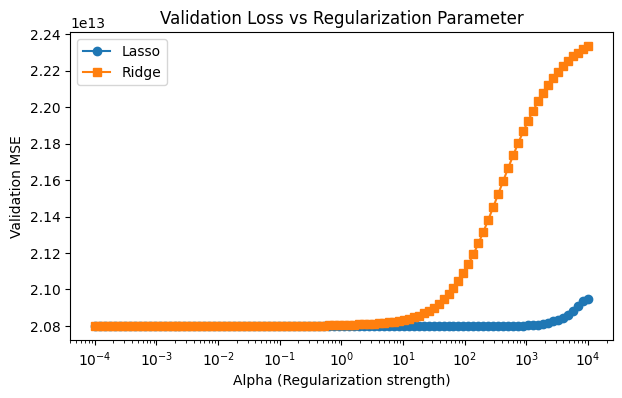

Best alpha for LASSO: 0.0001 with MSE on validation set: 20798486822672.637
Best alpha for RIDGE: 0.0001 with MSE on validation set: 20798487439112.043


In [215]:
# Model 2 and Model 3: LASSO and RIDGE Regression – Feature: Price

# Hyperparameter Tuning for LASSO and RIDGE
alphas = np.logspace(-4, 4, 100)  # 0.0001 to 10,000 

# Store results
results = {'lasso': [], 'ridge': []}

# Best alpha values
best_alpha_lasso = None
best_alpha_ridge = None
best_mse_lasso = float('inf')
best_mse_ridge = float('inf')

# Model 2: LASSO - Grid search over alphas
for a in alphas:
    model2_lasso_train = Lasso(alpha=a, max_iter=100000)
    model2_lasso_train.fit(X_train, y_train)
    y_pred_val = model2_lasso_train.predict(X_val)
    mse_val = mean_squared_error(y_val, y_pred_val)
    results['lasso'].append(mse_val)
    # Update best alpha for LASSO
    if mse_val < best_mse_lasso:
        best_mse_lasso = mse_val
        best_alpha_lasso = a

# Model 3: RIDGE – Grid search over alphas
for a in alphas:
    model3_ridge_train = Ridge(alpha=a)
    model3_ridge_train.fit(X_train, y_train)
    y_pred_val = model3_ridge_train.predict(X_val)
    mse_val = mean_squared_error(y_val, y_pred_val)
    results['ridge'].append(mse_val)
    # Update best alpha for RIDGE
    if mse_val < best_mse_ridge:
        best_mse_ridge = mse_val
        best_alpha_ridge = a

# Plotting Validation Loss vs Alpha for LASSO and RIDGE
plt.figure(figsize=(7,4))
plt.semilogx(alphas, results['lasso'], label='Lasso', marker='o')
plt.semilogx(alphas, results['ridge'], label='Ridge', marker='s')
plt.xlabel('Alpha (Regularization strength)')
plt.ylabel('Validation MSE')
plt.title('Validation Loss vs Regularization Parameter')
plt.legend()
plt.show()

# Displaying best alphas
print(f'Best alpha for LASSO: {best_alpha_lasso} with MSE on validation set: {best_mse_lasso}')
print(f'Best alpha for RIDGE: {best_alpha_ridge} with MSE on validation set: {best_mse_ridge}')

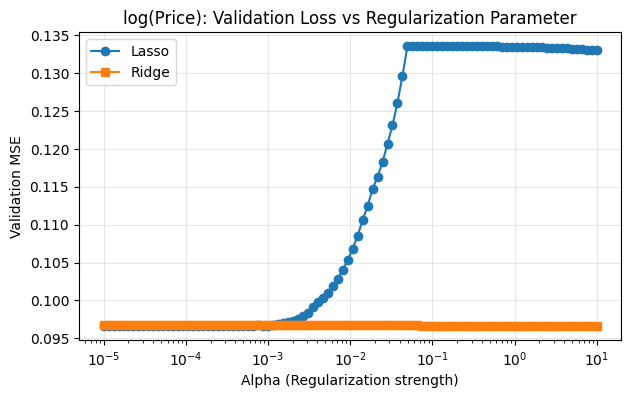

Best alpha for LASSO: 0.00021544346900318845 with MSE on validation set: 0.09660038754535388
Best alpha for RIDGE: 4.328761281083062 with MSE on validation set: 0.0966424693336694


In [216]:
# Model 2 and Model 3: LASSO and RIDGE Regression – Feature: logPrice

# Hyperparameter Tuning for LASSO and RIDGE
alphas_log = np.logspace(-5, 1, 100)  

# Store results
results_log = {'lasso': [], 'ridge': []}

# Best alpha values
best_alpha_lasso_log = None
best_alpha_ridge_log = None
best_mse_lasso_log = float('inf')
best_mse_ridge_log = float('inf')

# Model 2: LASSO - Grid search over alphas
for a in alphas_log:
    model2_lasso_train = Lasso(alpha=a, max_iter=100000)
    model2_lasso_train.fit(X_train, np.log(y_train))
    y_pred_val = model2_lasso_train.predict(X_val)
    mse_val = mean_squared_error(np.log(y_val), y_pred_val)
    results_log['lasso'].append(mse_val)
    if mse_val < best_mse_lasso_log:
        best_mse_lasso_log = mse_val
        best_alpha_lasso_log = a

# Model 3: RIDGE – Grid search over alphas
for a in alphas_log:
    model3_ridge_train = Ridge(alpha=a)
    model3_ridge_train.fit(X_train, np.log(y_train))
    y_pred_val = model3_ridge_train.predict(X_val)
    mse_val = mean_squared_error(np.log(y_val), y_pred_val)
    results_log['ridge'].append(mse_val)
    if mse_val < best_mse_ridge_log:
        best_mse_ridge_log = mse_val
        best_alpha_ridge_log = a

# Plotting Validation Loss vs Alpha for LASSO and RIDGE
plt.figure(figsize=(7,4))
plt.semilogx(alphas_log, results_log['lasso'], label='Lasso', marker='o')
plt.semilogx(alphas_log, results_log['ridge'], label='Ridge', marker='s')
plt.grid(True, alpha=0.3)
plt.xlabel('Alpha (Regularization strength)')
plt.ylabel('Validation MSE')
plt.title('log(Price): Validation Loss vs Regularization Parameter')
plt.legend()
plt.show()

# Displaying best alphas
print(f'Best alpha for LASSO: {best_alpha_lasso_log} with MSE on validation set: {best_mse_lasso_log}')
print(f'Best alpha for RIDGE: {best_alpha_ridge_log} with MSE on validation set: {best_mse_ridge_log}')



These are the alphas we will use as the hyperparameters for the model, as for these values we see the minimum MSE on the validation set.

In [217]:
# Final Models with Best Hyperparameters (Train + Validation Sets)

# Model 2: LASSO
model2_lasso_Price = Lasso(alpha=best_alpha_lasso, max_iter=100000)
model2_lasso_Price.fit(X_train_val, y_train_val)

model2_lasso_logPrice = Lasso(alpha=best_alpha_lasso_log, max_iter=100000)
model2_lasso_logPrice.fit(X_train_val, np.log(y_train_val))

# Model 3: RIDGE
model3_ridge_Price = Ridge(alpha=best_alpha_ridge)
model3_ridge_Price.fit(X_train_val, y_train_val)

model3_ridge_logPrice = Ridge(alpha=best_alpha_ridge_log)
model3_ridge_logPrice.fit(X_train_val, np.log(y_train_val))


,alpha,np.float64(4.328761281083062)
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


Table 3a with MAE and MSE of the predicted housing prices in the test set, based on Models 1-3 applied to the **price**.

In [218]:
# Evaluation (Price) using Train + Validation Sets

# MAE and MSE for all models with Price as target variable
table_final = pd.DataFrame({
    'Model': ['OLS', 'LASSO', 'RIDGE'],
    'MAE': [
        mean_absolute_error(y_test, model1_ols_Price.predict(X_test)),
        mean_absolute_error(y_test, model2_lasso_Price.predict(X_test)),
        mean_absolute_error(y_test, model3_ridge_Price.predict(X_test))
    ],
    'MSE': [
        mean_squared_error(y_test, model1_ols_Price.predict(X_test)),
        mean_squared_error(y_test, model2_lasso_Price.predict(X_test)),
        mean_squared_error(y_test, model3_ridge_Price.predict(X_test))
    ]
})

print("\nTable: MAE and MSE of predicted housing prices in the test set (Price, final models)")
print(table_final.to_string(index=False))

# Sort by MSE
print("\nModels ranked by MSE:")
print(table_final.sort_values('MSE')[['Model', 'MSE']].to_string(index=False))

# Sort by MAE
print("\nModels ranked by MAE:")
print(table_final.sort_values('MAE')[['Model', 'MAE']].to_string(index=False))



Table: MAE and MSE of predicted housing prices in the test set (Price, final models)
Model          MAE          MSE
  OLS 2.037760e+06 1.280918e+13
LASSO 2.037760e+06 1.280918e+13
RIDGE 2.037759e+06 1.280918e+13

Models ranked by MSE:
Model          MSE
RIDGE 1.280918e+13
LASSO 1.280918e+13
  OLS 1.280918e+13

Models ranked by MAE:
Model          MAE
RIDGE 2.037759e+06
LASSO 2.037760e+06
  OLS 2.037760e+06


Table 3b with MAE and MSE of the predicted housing prices in the test set, based on Models 1-3 applied to the **log price**. Note: Do not forget to transform your predicted log prices values back to **prices** again!

In [219]:
# Evaluation (logPrice) –––––

# Models to evaluate
model1_ols_logPrice
model2_lasso_logPrice
model3_ridge_logPrice

# MAE and MSE for all models with logPrice as target variables in one table
# predicted logPrices values need to be exponentiated to get Prices
table3b = pd.DataFrame({
    'Model': ['OLS', 'LASSO', 'RIDGE'],
    'MAE': [
        mean_absolute_error(y_test, np.exp(model1_ols_logPrice.predict(X_test))),
        mean_absolute_error(y_test, np.exp(model2_lasso_logPrice.predict(X_test))),
        mean_absolute_error(y_test, np.exp(model3_ridge_logPrice.predict(X_test)))
    ],
    'MSE': [
        mean_squared_error(y_test, np.exp(model1_ols_logPrice.predict(X_test))),
        mean_squared_error(y_test, np.exp(model2_lasso_logPrice.predict(X_test))),
        mean_squared_error(y_test, np.exp(model3_ridge_logPrice.predict(X_test)))
    ]
})

# Displaying the evaluation table
print("\nTable 3b: MAE and MSE of predicted housing prices in the test set (log(Price) as target variable)")
print((table3b).to_string(index=False))


Table 3b: MAE and MSE of predicted housing prices in the test set (log(Price) as target variable)
Model          MAE          MSE
  OLS 2.264826e+06 1.717393e+13
LASSO 2.264672e+06 1.723698e+13
RIDGE 2.259820e+06 1.703418e+13


Now, we take the best and second best model on **prices**. Test whether the differences in squared prediction errors are statistically significant (by the Diebold Mariano test). Redo this for the best and second best model on **log prices**. What is your conclusion?

The **Diebold–Mariano (1995) test** compares two forecasting models’ predictive accuracy by testing whether their **expected loss** is equal.

Formally, for forecast errors $e_{1,t}$ and $e_{2,t}$:

$$
H_0: E[L(e_{1,t}) - L(e_{2,t})] = 0
$$

where $L(\cdot)$ is a loss function (usually squared error).
The test statistic is based on the mean and autocovariance of the **loss differential**:

$$
d_t = L(e_{1,t}) - L(e_{2,t})
$$

A significantly positive mean $\bar{d}$ means model 1 has higher loss (worse performance).
A significantly negative mean means model 2 performs better.

In [220]:
# Comparing best models –––––

# On Prices
first_best_model = model3_ridge_Price
second_best_model = model2_lasso_Price

# Test whether the differences in squared prediction errors are statistically significant (by the Diebold Mariano test)

# Predicted test values for both models
y_pred_1 = first_best_model.predict(X_test)
y_pred_2 = second_best_model.predict(X_test)

# Forecast errors
e1 = y_test - y_pred_1
e2 = y_test - y_pred_2

# Squared errors
L1 = e1**2
L2 = e2**2

# Loss differential
d = L1 - L2

# Diebold-Mariano Test Implementation
def diebold_mariano(d, h=1):
    """
    Diebold-Mariano test for equal predictive accuracy.
    d: loss differential (array)
    h: forecast horizon (1 for one-step-ahead forecasts)
    """
    d = np.asarray(d)
    T = len(d)
    mean_d = np.mean(d)
    # Newey-West estimator of variance
    gamma = [np.cov(d[:-lag], d[lag:])[0,1] if lag>0 else np.var(d, ddof=1) for lag in range(h)]
    var_d = (gamma[0] + 2 * np.sum(gamma[1:])) / T
    DM_stat = mean_d / np.sqrt(var_d)
    p_value = 2 * (1 - stats.norm.cdf(abs(DM_stat)))
    return DM_stat, p_value

dm_stat, p_val = diebold_mariano(d)

print(f"Diebold-Mariano statistic: {dm_stat:.3f}")
print(f"P-value: {p_val:.4f}")
if p_val < 0.05:
    print("Reject null hypothesis: The predictive accuracies are significantly different.")
else:
    print("Fail to reject null hypothesis: No significant difference in predictive accuracies.")

Diebold-Mariano statistic: -2.323
P-value: 0.0202
Reject null hypothesis: The predictive accuracies are significantly different.


Conclusion: The negative and statistically significant coefficient indicates that the Ridge Regression has a lower squared error than the Lasso Regression, and this difference is statistically significant. 

In [221]:
# On logPrices
first_best_model = model3_ridge_logPrice
second_best_model = model2_lasso_logPrice

# Predicted test values for both models
y_pred_1 = first_best_model.predict(X_test)
y_pred_2 = second_best_model.predict(X_test)

# Forecast errors (need to exponentiate predictions to get Prices)
e1 = y_test - np.exp(y_pred_1)
e2 = y_test - np.exp(y_pred_2)

# Squared errors
L1 = e1**2
L2 = e2**2

# Loss differential
d = L1 - L2

# Diebold-Mariano Test Implementation
dm_stat, p_val = diebold_mariano(d)

print(f"Diebold-Mariano statistic: {dm_stat:.3f}")
print(f"P-value: {p_val:.4f}")
if p_val < 0.05:
    print("Reject null hypothesis: The predictive accuracies are significantly different.")
else:
    print("Fail to reject null hypothesis: No significant difference in predictive accuracies.")

Diebold-Mariano statistic: -1.773
P-value: 0.0762
Fail to reject null hypothesis: No significant difference in predictive accuracies.


Conclusion: The negative statistic indicates that while the Ridge Regression does have a lower squared error than the Lasso model, this difference is not statistically different at the 5% level, but is at the 10% level.

Test on statistical difference in squared prediction errors of the the best log price model versus the best price model. 

In [222]:
# Best Models
best_price_model = model3_ridge_Price
best_logprice_model = model3_ridge_logPrice

# Test on statistical difference in squared prediction errors of the the best log price model versus the best price model. 

# Predictions on the test set
y_pred_price = best_price_model.predict(X_test)

# Predict log(Price), then re-transform back to Price
y_pred_logprice = best_logprice_model.predict(X_test)
y_pred_logprice_back = np.exp(y_pred_logprice)

# Squared prediction errors
e_price = y_test - y_pred_price
e_logprice = y_test - y_pred_logprice_back

L_price = e_price**2
L_logprice = e_logprice**2

# Loss differential: positive → log(Price) model is better (smaller MSE)
d = L_price - L_logprice

# Diebold-Mariano Test
dm_stat, p_val = diebold_mariano(d)
print(f"Diebold-Mariano statistic: {dm_stat:.3f}")
print(f"P-value: {p_val:.4f}")
if p_val < 0.05:
    print("Reject null hypothesis: The predictive accuracies are significantly different.")
else:
    print("Fail to reject null hypothesis: No significant difference in predictive accuracies.")

Diebold-Mariano statistic: -1.694
P-value: 0.0903
Fail to reject null hypothesis: No significant difference in predictive accuracies.


A short recommendation whether you should model log prices or prices, and which model the company should use.


We see that this statistic comparing the best models - the Ridge Regression - on Price vs. Log Price leads to a negative but statistically insignificant Diebold-Mariano statistic at the 5% level, but significant at 10%. This, alongside the lower MSE and MAE for the Price model indicates that predictions are generally more accurate on the price model using Ridge Regression. The regularisation parameters were also very low for the regression on Price, effectively rendering the ridge and lasso to an OLS model. With the almost negligible difference in MSE and MAE, the models are practically the same despite the significant Diebold-Mariano test. 

This is, however, not all we should look at when choosing between modelling Log-Price and Price, we should also look at whether the assumptions we make when doing regressions hold. We saw that the Price was further away from normality than Log Price, and if this difference is present in the residuals it might be better from a statistical standpoint to use the Log Price model (in appendix: Log Price residuals relatively normally distributed but normality rejected for resids on Price). This is however, a practical model for use by a company, so simply picking a model with the best results on the test data might be the best option - and this was the Ridge Regression model on prices. 

## **Robustness**

Change our training/validation/testing rule into 70/10/20.

In [223]:
# Robustness –––––

# Data preparation

# Splitting the data into features and target variable
X_robust = df.drop(columns=['Price'])
y_robust = df['Price']

# Splitting the data into training (70%), validation (10%), and testing (20%) sets
X_train_robust = X_robust.iloc[:int(0.7*len(X_robust))]
y_train_robust = y_robust.iloc[:int(0.7*len(y_robust))]
X_val_robust = X_robust.iloc[int(0.7*len(X_robust)):int(0.8*len(X_robust))]
y_val_robust = y_robust.iloc[int(0.7*len(y_robust)):int(0.8*len(y_robust))]
X_test_robust = X_robust.iloc[int(0.8*len(X_robust)):]
y_test_robust = y_robust.iloc[int(0.8*len(y_robust)):]

# Train + Validation set for final evaluation
X_train_val_robust = pd.concat([X_train_robust, X_val_robust], ignore_index=True)
y_train_val_robust = pd.concat([y_train_robust, y_val_robust], ignore_index=True)


Table 4 with the new tuning parameters.

Compare these with the original hyperparameters and comment on any differences.

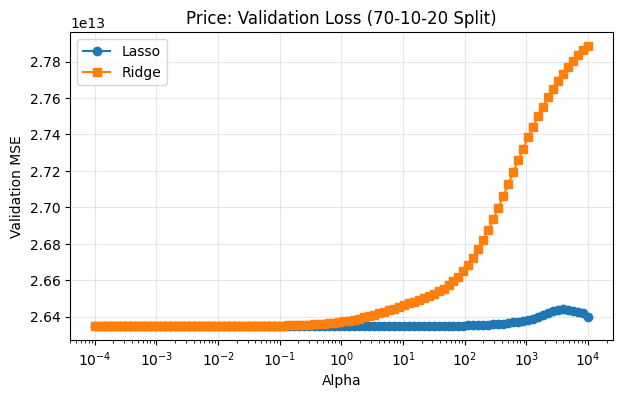

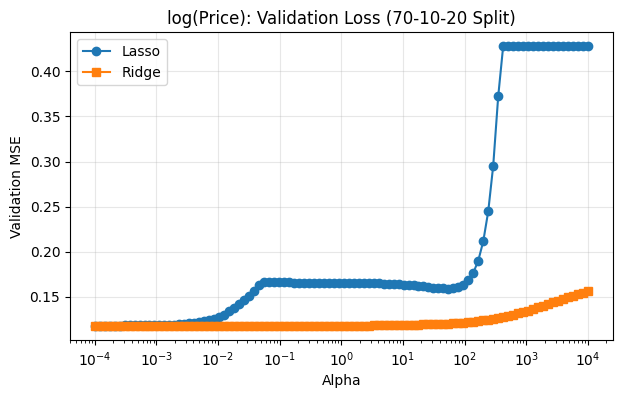


Price Models (70-10-20 Split):
  LASSO - Best alpha: 0.000100, MSE: 26348630169446.67
  RIDGE - Best alpha: 0.000100, MSE: 26348632943994.01

log(Price) Models (70-10-20 Split):
  LASSO - Best alpha: 0.000100, MSE: 0.117499
  RIDGE - Best alpha: 0.000100, MSE: 0.117284

Table 5: Hyperparameters for robustness check (70-10-20 split)
    Target Model  Best Alpha  Validation MSE
     Price LASSO      0.0001    2.634863e+13
     Price RIDGE      0.0001    2.634863e+13
log(Price) LASSO      0.0001    1.174990e-01
log(Price) RIDGE      0.0001    1.172841e-01


In [224]:
# Alpha range to search
alphas_robust = np.logspace(-4, 4, 100)

# Storage for validation MSE
results_price_robust = {'lasso': [], 'ridge': []}
results_log_robust = {'lasso': [], 'ridge': []}

# Best alpha 
best_alpha_lasso_price_robust = None
best_alpha_ridge_price_robust = None
best_mse_lasso_price_robust = float('inf')
best_mse_ridge_price_robust = float('inf')

best_alpha_lasso_log_robust = None
best_alpha_ridge_log_robust = None
best_mse_lasso_log_robust = float('inf')
best_mse_ridge_log_robust = float('inf')

# Grid search for LASSO - Price
for a in alphas_robust:
    model = Lasso(alpha=a, max_iter=100000)
    model.fit(X_train_robust, y_train_robust)
    mse = mean_squared_error(y_val_robust, model.predict(X_val_robust))
    results_price_robust['lasso'].append(mse)
    if mse < best_mse_lasso_price_robust:
        best_mse_lasso_price_robust = mse
        best_alpha_lasso_price_robust = a

# Grid search for RIDGE - Price
for a in alphas_robust:
    model = Ridge(alpha=a)
    model.fit(X_train_robust, y_train_robust)
    mse = mean_squared_error(y_val_robust, model.predict(X_val_robust))
    results_price_robust['ridge'].append(mse)
    if mse < best_mse_ridge_price_robust:
        best_mse_ridge_price_robust = mse
        best_alpha_ridge_price_robust = a

# Grid search for LASSO - log(Price)
for a in alphas_robust:
    model = Lasso(alpha=a, max_iter=100000)
    model.fit(X_train_robust, np.log(y_train_robust))
    mse = mean_squared_error(np.log(y_val_robust), model.predict(X_val_robust))
    results_log_robust['lasso'].append(mse)
    if mse < best_mse_lasso_log_robust:
        best_mse_lasso_log_robust = mse
        best_alpha_lasso_log_robust = a

# Grid search for RIDGE - log(Price)
for a in alphas_robust:
    model = Ridge(alpha=a)
    model.fit(X_train_robust, np.log(y_train_robust))
    mse = mean_squared_error(np.log(y_val_robust), model.predict(X_val_robust))
    results_log_robust['ridge'].append(mse)
    if mse < best_mse_ridge_log_robust:
        best_mse_ridge_log_robust = mse
        best_alpha_ridge_log_robust = a

# Plot validation curves - Price
plt.figure(figsize=(7,4))
plt.semilogx(alphas_robust, results_price_robust['lasso'], label='Lasso', marker='o')
plt.semilogx(alphas_robust, results_price_robust['ridge'], label='Ridge', marker='s')
plt.xlabel('Alpha')
plt.ylabel('Validation MSE')
plt.title('Price: Validation Loss (70-10-20 Split)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot validation curves - log(Price)
plt.figure(figsize=(7,4))
plt.semilogx(alphas_robust, results_log_robust['lasso'], label='Lasso', marker='o')
plt.semilogx(alphas_robust, results_log_robust['ridge'], label='Ridge', marker='s')
plt.xlabel('Alpha')
plt.ylabel('Validation MSE')
plt.title('log(Price): Validation Loss (70-10-20 Split)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Results summary
print("\nPrice Models (70-10-20 Split):")
print(f"  LASSO - Best alpha: {best_alpha_lasso_price_robust:.6f}, MSE: {best_mse_lasso_price_robust:.2f}")
print(f"  RIDGE - Best alpha: {best_alpha_ridge_price_robust:.6f}, MSE: {best_mse_ridge_price_robust:.2f}")

print("\nlog(Price) Models (70-10-20 Split):")
print(f"  LASSO - Best alpha: {best_alpha_lasso_log_robust:.6f}, MSE: {best_mse_lasso_log_robust:.6f}")
print(f"  RIDGE - Best alpha: {best_alpha_ridge_log_robust:.6f}, MSE: {best_mse_ridge_log_robust:.6f}")

# Comparison table
table_robust = pd.DataFrame({
    'Target': ['Price', 'Price', 'log(Price)', 'log(Price)'],
    'Model': ['LASSO', 'RIDGE', 'LASSO', 'RIDGE'],
    'Best Alpha': [best_alpha_lasso_price_robust, best_alpha_ridge_price_robust, 
                   best_alpha_lasso_log_robust, best_alpha_ridge_log_robust],
    'Validation MSE': [best_mse_lasso_price_robust, best_mse_ridge_price_robust, 
                       best_mse_lasso_log_robust, best_mse_ridge_log_robust]
})

print("\nTable 5: Hyperparameters for robustness check (70-10-20 split)")
print(table_robust.to_string(index=False))



Tables 5a and 5b similar to Tables 3a and 3b with the new MAE and MSE values of all 3 models.

In [225]:
# Train final models with best alphas from robustness split (using train + validation)

# Price models
model1_ols_Price_robust = LinearRegression()
model1_ols_Price_robust.fit(X_train_val_robust, y_train_val_robust)

model2_lasso_Price_robust = Lasso(alpha=best_alpha_lasso_price_robust, max_iter=100000)
model2_lasso_Price_robust.fit(X_train_val_robust, y_train_val_robust)

model3_ridge_Price_robust = Ridge(alpha=best_alpha_ridge_price_robust)
model3_ridge_Price_robust.fit(X_train_val_robust, y_train_val_robust)

# log(Price) models
model1_ols_logPrice_robust = LinearRegression()
model1_ols_logPrice_robust.fit(X_train_val_robust, np.log(y_train_val_robust))

model2_lasso_logPrice_robust = Lasso(alpha=best_alpha_lasso_log_robust, max_iter=100000)
model2_lasso_logPrice_robust.fit(X_train_val_robust, np.log(y_train_val_robust))

model3_ridge_logPrice_robust = Ridge(alpha=best_alpha_ridge_log_robust)
model3_ridge_logPrice_robust.fit(X_train_val_robust, np.log(y_train_val_robust))

# Table 5a: Evaluation on Price models
table5a = pd.DataFrame({
    'Model': ['OLS', 'LASSO', 'RIDGE'],
    'MAE': [
        mean_absolute_error(y_test_robust, model1_ols_Price_robust.predict(X_test_robust)),
        mean_absolute_error(y_test_robust, model2_lasso_Price_robust.predict(X_test_robust)),
        mean_absolute_error(y_test_robust, model3_ridge_Price_robust.predict(X_test_robust))
    ],
    'MSE': [
        mean_squared_error(y_test_robust, model1_ols_Price_robust.predict(X_test_robust)),
        mean_squared_error(y_test_robust, model2_lasso_Price_robust.predict(X_test_robust)),
        mean_squared_error(y_test_robust, model3_ridge_Price_robust.predict(X_test_robust))
    ]
})

print("\nTable 5a: MAE and MSE (Price, 70-10-20 split)")
print(table5a.to_string(index=False))

# Table 5b: Evaluation on log(Price) models (transform back to price level)
table5b = pd.DataFrame({
    'Model': ['OLS', 'LASSO', 'RIDGE'],
    'MAE': [
        mean_absolute_error(y_test_robust, np.exp(model1_ols_logPrice_robust.predict(X_test_robust))),
        mean_absolute_error(y_test_robust, np.exp(model2_lasso_logPrice_robust.predict(X_test_robust))),
        mean_absolute_error(y_test_robust, np.exp(model3_ridge_logPrice_robust.predict(X_test_robust)))
    ],
    'MSE': [
        mean_squared_error(y_test_robust, np.exp(model1_ols_logPrice_robust.predict(X_test_robust))),
        mean_squared_error(y_test_robust, np.exp(model2_lasso_logPrice_robust.predict(X_test_robust))),
        mean_squared_error(y_test_robust, np.exp(model3_ridge_logPrice_robust.predict(X_test_robust)))
    ]
})

print("\nTable 5b: MAE and MSE (log(Price), 70-10-20 split)")
print(table5b.to_string(index=False))

# Identify best models
best_price_model_robust = table5a.loc[table5a['MSE'].idxmin(), 'Model']
best_log_model_robust = table5b.loc[table5b['MSE'].idxmin(), 'Model']

print(f"\nBest Price model (70-10-20): {best_price_model_robust}")
print(f"Best log(Price) model (70-10-20): {best_log_model_robust}")



Table 5a: MAE and MSE (Price, 70-10-20 split)
Model          MAE          MSE
  OLS 2.037760e+06 1.280918e+13
LASSO 2.037760e+06 1.280918e+13
RIDGE 2.037759e+06 1.280918e+13

Table 5b: MAE and MSE (log(Price), 70-10-20 split)
Model          MAE          MSE
  OLS 2.264826e+06 1.717393e+13
LASSO 2.264559e+06 1.720600e+13
RIDGE 2.264826e+06 1.717392e+13

Best Price model (70-10-20): RIDGE
Best log(Price) model (70-10-20): RIDGE


Again conduct the Diebold Mariano test on the best log price model against the best price model.

In [226]:
# Diebold-Mariano Test: Best Price model (RIDGE) vs Best log(Price) model (RIDGE)
# For robustness check (70-10-20 split)

# Get predictions
y_pred_ridge_price_robust = model3_ridge_Price_robust.predict(X_test_robust)
y_pred_ridge_log_robust = np.exp(model3_ridge_logPrice_robust.predict(X_test_robust))

# Forecast errors
e_ridge_price_robust = y_test_robust - y_pred_ridge_price_robust
e_ridge_log_robust = y_test_robust - y_pred_ridge_log_robust

# Squared errors
L_ridge_price_robust = e_ridge_price_robust**2
L_ridge_log_robust = e_ridge_log_robust**2

# Loss differential
d_robust = L_ridge_log_robust - L_ridge_price_robust

# Diebold-Mariano Test
def diebold_mariano(d, h=1):
    d = np.asarray(d)
    T = len(d)
    mean_d = np.mean(d)
    gamma = [np.cov(d[:-lag], d[lag:])[0,1] if lag>0 else np.var(d, ddof=1) for lag in range(h)]
    var_d = (gamma[0] + 2 * np.sum(gamma[1:])) / T
    DM_stat = mean_d / np.sqrt(var_d)
    p_value = 2 * (1 - stats.norm.cdf(abs(DM_stat)))
    return DM_stat, p_value

dm_stat_robust, p_val_robust = diebold_mariano(d_robust)

print("Diebold-Mariano Test: RIDGE (Price) vs RIDGE (log Price) - 70-10-20 Split")
print("="*60)
print(f"DM statistic: {dm_stat_robust:.3f}")
print(f"P-value: {p_val_robust:.4f}")

if p_val_robust < 0.05:
    print("Conclusion: The predictive accuracies are significantly different.")
else:
    print("Conclusion: No significant difference in predictive accuracies.")


Diebold-Mariano Test: RIDGE (Price) vs RIDGE (log Price) - 70-10-20 Split
DM statistic: 1.746
P-value: 0.0809
Conclusion: No significant difference in predictive accuracies.


Interpretation of Table 5 and explanation whether our short recommendation should be updated (and how)?

We see in table 5 the ridge price model and the ridge log price model has the lowest MSE, the same result as we got with the different data split. Also, with the Diebold Mariano test we see that the Lasso Log Price model seems to have a lower error, although this difference is not statistically significant at 5%. Based on this, since the Ridge model on Prices seems to be less sensitive to data selection (we see that the ridge log price alpha hyperparameter has changed considerably relative to 60-20-20 split), the Ridge model on prices is the most recommended model.

## **Appendix**

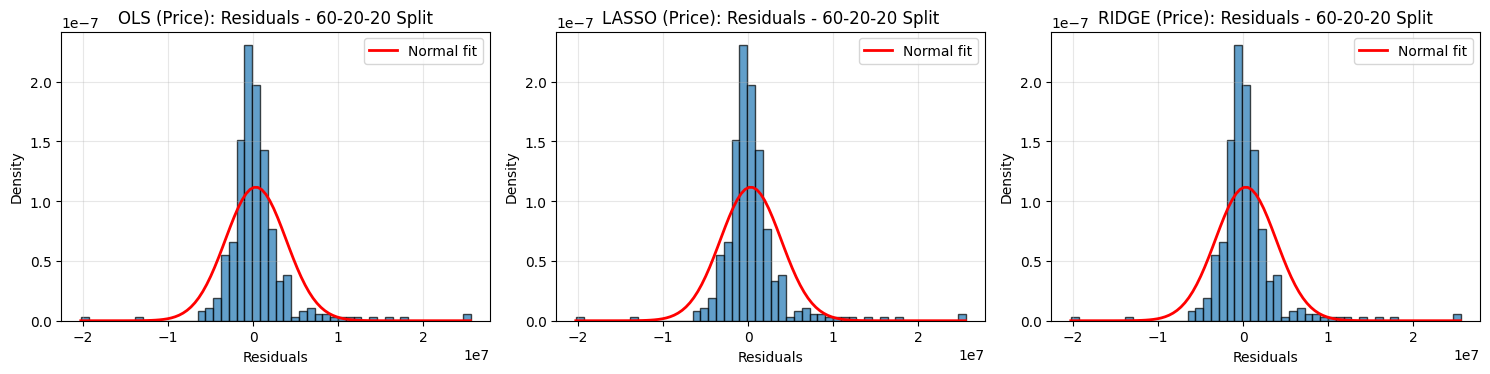

APPENDIX: PRICE MODELS - Normality Tests (60-20-20 Split)

Jarque-Bera Test (Null: residuals are normally distributed)
   OLS:   JB statistic = 5185.1776, p-value = 0.0000
          Conclusion: Residuals deviate from normality
   LASSO: JB statistic = 5185.1776, p-value = 0.0000
          Conclusion: Residuals deviate from normality
   RIDGE: JB statistic = 5185.1804, p-value = 0.0000
          Conclusion: Residuals deviate from normality

Shapiro-Wilk Test (Null: residuals are normally distributed)
   OLS:   W statistic = 0.7550, p-value = 0.0000
          Conclusion: Residuals deviate from normality
   LASSO: W statistic = 0.7550, p-value = 0.0000
          Conclusion: Residuals deviate from normality
   RIDGE: W statistic = 0.7550, p-value = 0.0000
          Conclusion: Residuals deviate from normality


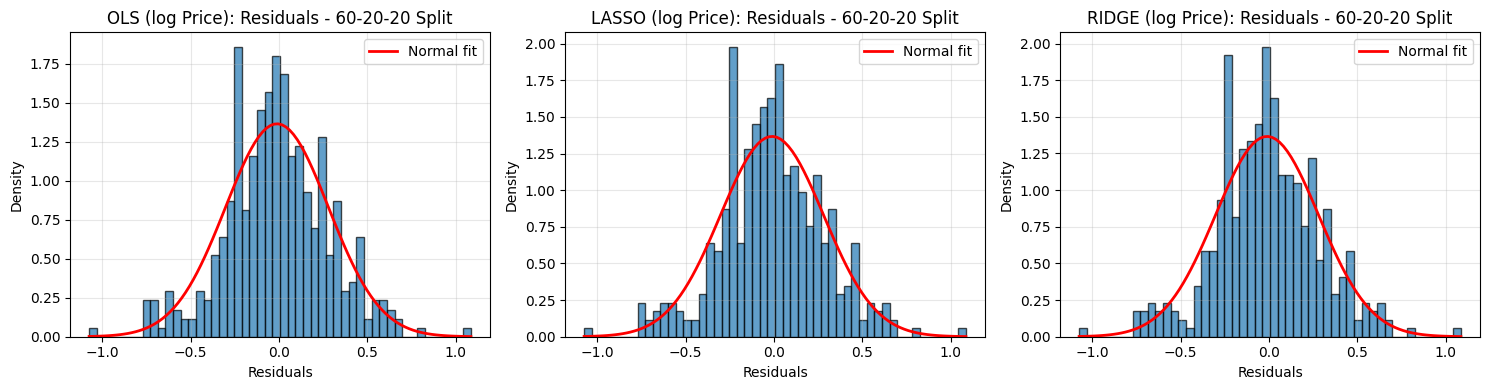


APPENDIX: LOG PRICE MODELS - Normality Tests (60-20-20 Split)

Jarque-Bera Test (Null: residuals are normally distributed)
   OLS:   JB statistic = 8.4738, p-value = 0.0145
          Conclusion: Residuals deviate from normality
   LASSO: JB statistic = 8.2393, p-value = 0.0163
          Conclusion: Residuals deviate from normality
   RIDGE: JB statistic = 8.3849, p-value = 0.0151
          Conclusion: Residuals deviate from normality

Shapiro-Wilk Test (Null: residuals are normally distributed)
   OLS:   W statistic = 0.9917, p-value = 0.0250
          Conclusion: Residuals deviate from normality
   LASSO: W statistic = 0.9919, p-value = 0.0285
          Conclusion: Residuals deviate from normality
   RIDGE: W statistic = 0.9917, p-value = 0.0259
          Conclusion: Residuals deviate from normality


In [227]:
# ========================================
# APPENDIX: Residual Analysis for 60-20-20 Split
# ========================================
# Using models already fitted in main analysis

# ========================================
# PRICE MODELS - Residuals with Normal Fit
# ========================================

# Get predictions
pred_ols = model1_ols_Price.predict(X_test)
pred_lasso = model2_lasso_Price.predict(X_test)
pred_ridge = model3_ridge_Price.predict(X_test)

# Calculate residuals
resid_ols = y_test - pred_ols
resid_lasso = y_test - pred_lasso
resid_ridge = y_test - pred_ridge

# Histogram with Normal Fit
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# OLS
axes[0].hist(resid_ols, bins=50, density=True, alpha=0.7, edgecolor='black')
mu, sigma = resid_ols.mean(), resid_ols.std()
x = np.linspace(resid_ols.min(), resid_ols.max(), 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Density')
axes[0].set_title('OLS (Price): Residuals - 60-20-20 Split')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LASSO
axes[1].hist(resid_lasso, bins=50, density=True, alpha=0.7, edgecolor='black')
mu, sigma = resid_lasso.mean(), resid_lasso.std()
x = np.linspace(resid_lasso.min(), resid_lasso.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('LASSO (Price): Residuals - 60-20-20 Split')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# RIDGE
axes[2].hist(resid_ridge, bins=50, density=True, alpha=0.7, edgecolor='black')
mu, sigma = resid_ridge.mean(), resid_ridge.std()
x = np.linspace(resid_ridge.min(), resid_ridge.max(), 100)
axes[2].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Density')
axes[2].set_title('RIDGE (Price): Residuals - 60-20-20 Split')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Normality Tests
print("="*60)
print("APPENDIX: PRICE MODELS - Normality Tests (60-20-20 Split)")
print("="*60)

# Jarque-Bera Test
jb_ols, jb_p_ols = stats.jarque_bera(resid_ols)
jb_lasso, jb_p_lasso = stats.jarque_bera(resid_lasso)
jb_ridge, jb_p_ridge = stats.jarque_bera(resid_ridge)

print("\nJarque-Bera Test (Null: residuals are normally distributed)")
print(f"   OLS:   JB statistic = {jb_ols:.4f}, p-value = {jb_p_ols:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if jb_p_ols > 0.05 else 'Residuals deviate from normality'}")

print(f"   LASSO: JB statistic = {jb_lasso:.4f}, p-value = {jb_p_lasso:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if jb_p_lasso > 0.05 else 'Residuals deviate from normality'}")

print(f"   RIDGE: JB statistic = {jb_ridge:.4f}, p-value = {jb_p_ridge:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if jb_p_ridge > 0.05 else 'Residuals deviate from normality'}")

# Shapiro-Wilk Test
sw_ols, sw_p_ols = stats.shapiro(resid_ols)
sw_lasso, sw_p_lasso = stats.shapiro(resid_lasso)
sw_ridge, sw_p_ridge = stats.shapiro(resid_ridge)

print("\nShapiro-Wilk Test (Null: residuals are normally distributed)")
print(f"   OLS:   W statistic = {sw_ols:.4f}, p-value = {sw_p_ols:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if sw_p_ols > 0.05 else 'Residuals deviate from normality'}")

print(f"   LASSO: W statistic = {sw_lasso:.4f}, p-value = {sw_p_lasso:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if sw_p_lasso > 0.05 else 'Residuals deviate from normality'}")

print(f"   RIDGE: W statistic = {sw_ridge:.4f}, p-value = {sw_p_ridge:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if sw_p_ridge > 0.05 else 'Residuals deviate from normality'}")

# ========================================
# LOG PRICE MODELS - Residuals with Normal Fit
# ========================================

# Get predictions (log scale)
pred_ols_log = model1_ols_logPrice.predict(X_test)
pred_lasso_log = model2_lasso_logPrice.predict(X_test)
pred_ridge_log = model3_ridge_logPrice.predict(X_test)

# Calculate residuals (log scale)
resid_ols_log = np.log(y_test) - pred_ols_log
resid_lasso_log = np.log(y_test) - pred_lasso_log
resid_ridge_log = np.log(y_test) - pred_ridge_log

# Histogram with Normal Fit
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# OLS
axes[0].hist(resid_ols_log, bins=50, density=True, alpha=0.7, edgecolor='black')
mu, sigma = resid_ols_log.mean(), resid_ols_log.std()
x = np.linspace(resid_ols_log.min(), resid_ols_log.max(), 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Density')
axes[0].set_title('OLS (log Price): Residuals - 60-20-20 Split')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LASSO
axes[1].hist(resid_lasso_log, bins=50, density=True, alpha=0.7, edgecolor='black')
mu, sigma = resid_lasso_log.mean(), resid_lasso_log.std()
x = np.linspace(resid_lasso_log.min(), resid_lasso_log.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('LASSO (log Price): Residuals - 60-20-20 Split')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# RIDGE
axes[2].hist(resid_ridge_log, bins=50, density=True, alpha=0.7, edgecolor='black')
mu, sigma = resid_ridge_log.mean(), resid_ridge_log.std()
x = np.linspace(resid_ridge_log.min(), resid_ridge_log.max(), 100)
axes[2].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Density')
axes[2].set_title('RIDGE (log Price): Residuals - 60-20-20 Split')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Normality Tests for Log Price Models
print("\n" + "="*60)
print("APPENDIX: LOG PRICE MODELS - Normality Tests (60-20-20 Split)")
print("="*60)

# Jarque-Bera Test
jb_ols_log, jb_p_ols_log = stats.jarque_bera(resid_ols_log)
jb_lasso_log, jb_p_lasso_log = stats.jarque_bera(resid_lasso_log)
jb_ridge_log, jb_p_ridge_log = stats.jarque_bera(resid_ridge_log)

print("\nJarque-Bera Test (Null: residuals are normally distributed)")
print(f"   OLS:   JB statistic = {jb_ols_log:.4f}, p-value = {jb_p_ols_log:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if jb_p_ols_log > 0.05 else 'Residuals deviate from normality'}")

print(f"   LASSO: JB statistic = {jb_lasso_log:.4f}, p-value = {jb_p_lasso_log:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if jb_p_lasso_log > 0.05 else 'Residuals deviate from normality'}")

print(f"   RIDGE: JB statistic = {jb_ridge_log:.4f}, p-value = {jb_p_ridge_log:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if jb_p_ridge_log > 0.05 else 'Residuals deviate from normality'}")

# Shapiro-Wilk Test
sw_ols_log, sw_p_ols_log = stats.shapiro(resid_ols_log)
sw_lasso_log, sw_p_lasso_log = stats.shapiro(resid_lasso_log)
sw_ridge_log, sw_p_ridge_log = stats.shapiro(resid_ridge_log)

print("\nShapiro-Wilk Test (Null: residuals are normally distributed)")
print(f"   OLS:   W statistic = {sw_ols_log:.4f}, p-value = {sw_p_ols_log:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if sw_p_ols_log > 0.05 else 'Residuals deviate from normality'}")

print(f"   LASSO: W statistic = {sw_lasso_log:.4f}, p-value = {sw_p_lasso_log:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if sw_p_lasso_log > 0.05 else 'Residuals deviate from normality'}")

print(f"   RIDGE: W statistic = {sw_ridge_log:.4f}, p-value = {sw_p_ridge_log:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if sw_p_ridge_log > 0.05 else 'Residuals deviate from normality'}")


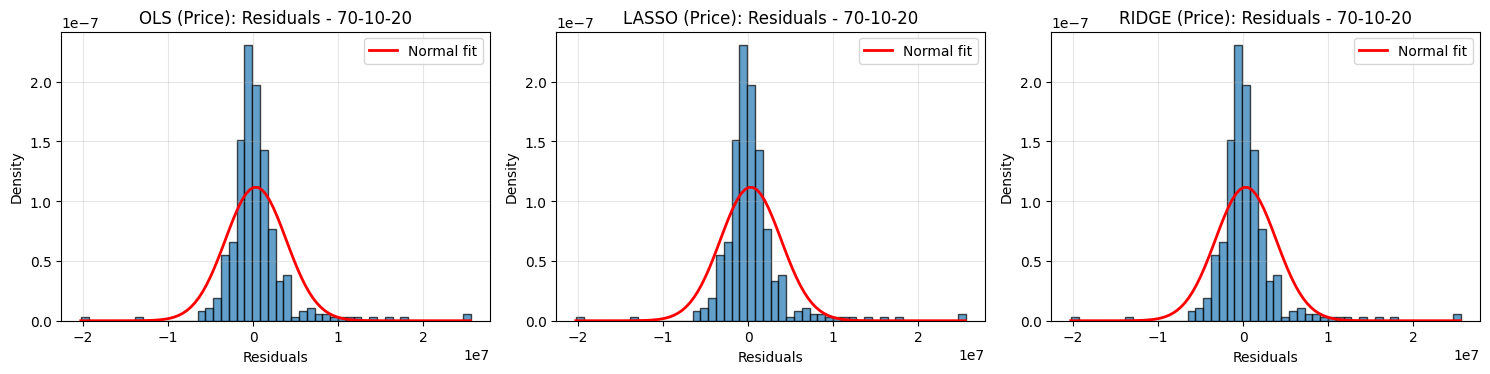

PRICE MODELS - Normality Tests (70-10-20 Split)

Jarque-Bera Test (Null: residuals are normally distributed)
   OLS:   JB statistic = 5185.1776, p-value = 0.0000
          Conclusion: Residuals deviate from normality
   LASSO: JB statistic = 5185.1776, p-value = 0.0000
          Conclusion: Residuals deviate from normality
   RIDGE: JB statistic = 5185.1804, p-value = 0.0000
          Conclusion: Residuals deviate from normality

Shapiro-Wilk Test (Null: residuals are normally distributed)
   OLS:   W statistic = 0.7550, p-value = 0.0000
          Conclusion: Residuals deviate from normality
   LASSO: W statistic = 0.7550, p-value = 0.0000
          Conclusion: Residuals deviate from normality
   RIDGE: W statistic = 0.7550, p-value = 0.0000
          Conclusion: Residuals deviate from normality


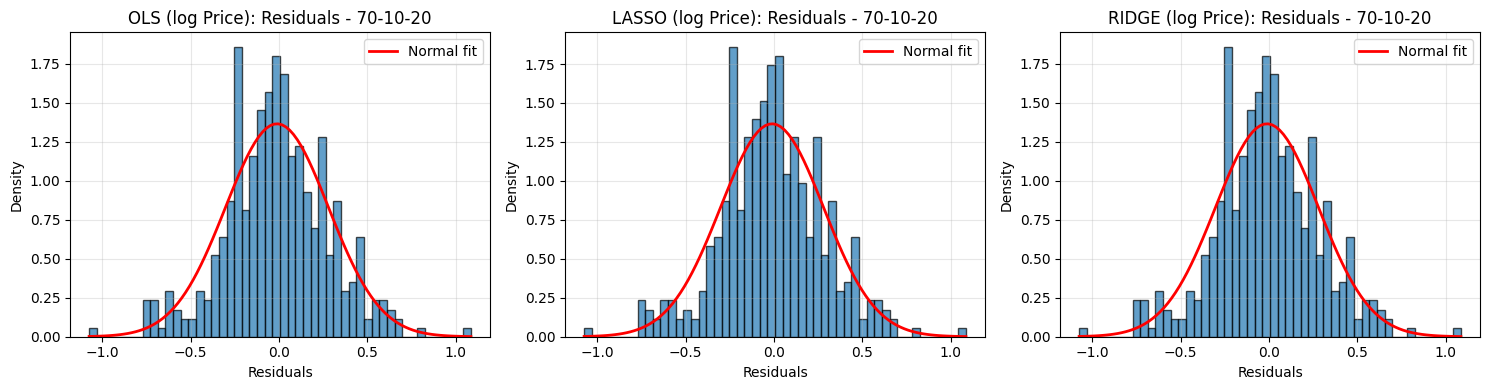


LOG PRICE MODELS - Normality Tests (70-10-20 Split)

Jarque-Bera Test (Null: residuals are normally distributed)
   OLS:   JB statistic = 8.4738, p-value = 0.0145
          Conclusion: Residuals deviate from normality
   LASSO: JB statistic = 8.3673, p-value = 0.0152
          Conclusion: Residuals deviate from normality
   RIDGE: JB statistic = 8.4738, p-value = 0.0145
          Conclusion: Residuals deviate from normality

Shapiro-Wilk Test (Null: residuals are normally distributed)
   OLS:   W statistic = 0.9917, p-value = 0.0250
          Conclusion: Residuals deviate from normality
   LASSO: W statistic = 0.9918, p-value = 0.0268
          Conclusion: Residuals deviate from normality
   RIDGE: W statistic = 0.9917, p-value = 0.0250
          Conclusion: Residuals deviate from normality


In [228]:
# Residual Analysis for Robustness Check (70-10-20 Split)

# ========================================
# PRICE MODELS - Residuals with Normal Fit
# ========================================

# Get predictions
pred_ols_robust = model1_ols_Price_robust.predict(X_test_robust)
pred_lasso_robust = model2_lasso_Price_robust.predict(X_test_robust)
pred_ridge_robust = model3_ridge_Price_robust.predict(X_test_robust)

# Calculate residuals
resid_ols_robust = y_test_robust - pred_ols_robust
resid_lasso_robust = y_test_robust - pred_lasso_robust
resid_ridge_robust = y_test_robust - pred_ridge_robust

# Histogram with Normal Fit
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# OLS
axes[0].hist(resid_ols_robust, bins=50, density=True, alpha=0.7, edgecolor='black')
mu, sigma = resid_ols_robust.mean(), resid_ols_robust.std()
x = np.linspace(resid_ols_robust.min(), resid_ols_robust.max(), 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Density')
axes[0].set_title('OLS (Price): Residuals - 70-10-20')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LASSO
axes[1].hist(resid_lasso_robust, bins=50, density=True, alpha=0.7, edgecolor='black')
mu, sigma = resid_lasso_robust.mean(), resid_lasso_robust.std()
x = np.linspace(resid_lasso_robust.min(), resid_lasso_robust.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('LASSO (Price): Residuals - 70-10-20')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# RIDGE
axes[2].hist(resid_ridge_robust, bins=50, density=True, alpha=0.7, edgecolor='black')
mu, sigma = resid_ridge_robust.mean(), resid_ridge_robust.std()
x = np.linspace(resid_ridge_robust.min(), resid_ridge_robust.max(), 100)
axes[2].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Density')
axes[2].set_title('RIDGE (Price): Residuals - 70-10-20')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Normality Tests for Price Models
print("="*60)
print("PRICE MODELS - Normality Tests (70-10-20 Split)")
print("="*60)

# Jarque-Bera Test
jb_ols_robust, jb_p_ols_robust = stats.jarque_bera(resid_ols_robust)
jb_lasso_robust, jb_p_lasso_robust = stats.jarque_bera(resid_lasso_robust)
jb_ridge_robust, jb_p_ridge_robust = stats.jarque_bera(resid_ridge_robust)

print("\nJarque-Bera Test (Null: residuals are normally distributed)")
print(f"   OLS:   JB statistic = {jb_ols_robust:.4f}, p-value = {jb_p_ols_robust:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if jb_p_ols_robust > 0.05 else 'Residuals deviate from normality'}")

print(f"   LASSO: JB statistic = {jb_lasso_robust:.4f}, p-value = {jb_p_lasso_robust:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if jb_p_lasso_robust > 0.05 else 'Residuals deviate from normality'}")

print(f"   RIDGE: JB statistic = {jb_ridge_robust:.4f}, p-value = {jb_p_ridge_robust:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if jb_p_ridge_robust > 0.05 else 'Residuals deviate from normality'}")

# Shapiro-Wilk Test
sw_ols_robust, sw_p_ols_robust = stats.shapiro(resid_ols_robust)
sw_lasso_robust, sw_p_lasso_robust = stats.shapiro(resid_lasso_robust)
sw_ridge_robust, sw_p_ridge_robust = stats.shapiro(resid_ridge_robust)

print("\nShapiro-Wilk Test (Null: residuals are normally distributed)")
print(f"   OLS:   W statistic = {sw_ols_robust:.4f}, p-value = {sw_p_ols_robust:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if sw_p_ols_robust > 0.05 else 'Residuals deviate from normality'}")

print(f"   LASSO: W statistic = {sw_lasso_robust:.4f}, p-value = {sw_p_lasso_robust:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if sw_p_lasso_robust > 0.05 else 'Residuals deviate from normality'}")

print(f"   RIDGE: W statistic = {sw_ridge_robust:.4f}, p-value = {sw_p_ridge_robust:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if sw_p_ridge_robust > 0.05 else 'Residuals deviate from normality'}")

# ========================================
# LOG PRICE MODELS - Residuals with Normal Fit
# ========================================

# Get predictions (log scale)
pred_ols_log_robust = model1_ols_logPrice_robust.predict(X_test_robust)
pred_lasso_log_robust = model2_lasso_logPrice_robust.predict(X_test_robust)
pred_ridge_log_robust = model3_ridge_logPrice_robust.predict(X_test_robust)

# Calculate residuals (log scale)
resid_ols_log_robust = np.log(y_test_robust) - pred_ols_log_robust
resid_lasso_log_robust = np.log(y_test_robust) - pred_lasso_log_robust
resid_ridge_log_robust = np.log(y_test_robust) - pred_ridge_log_robust

# Histogram with Normal Fit
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# OLS
axes[0].hist(resid_ols_log_robust, bins=50, density=True, alpha=0.7, edgecolor='black')
mu, sigma = resid_ols_log_robust.mean(), resid_ols_log_robust.std()
x = np.linspace(resid_ols_log_robust.min(), resid_ols_log_robust.max(), 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Density')
axes[0].set_title('OLS (log Price): Residuals - 70-10-20')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LASSO
axes[1].hist(resid_lasso_log_robust, bins=50, density=True, alpha=0.7, edgecolor='black')
mu, sigma = resid_lasso_log_robust.mean(), resid_lasso_log_robust.std()
x = np.linspace(resid_lasso_log_robust.min(), resid_lasso_log_robust.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('LASSO (log Price): Residuals - 70-10-20')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# RIDGE
axes[2].hist(resid_ridge_log_robust, bins=50, density=True, alpha=0.7, edgecolor='black')
mu, sigma = resid_ridge_log_robust.mean(), resid_ridge_log_robust.std()
x = np.linspace(resid_ridge_log_robust.min(), resid_ridge_log_robust.max(), 100)
axes[2].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Density')
axes[2].set_title('RIDGE (log Price): Residuals - 70-10-20')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Normality Tests for Log Price Models
print("\n" + "="*60)
print("LOG PRICE MODELS - Normality Tests (70-10-20 Split)")
print("="*60)

# Jarque-Bera Test
jb_ols_log_robust, jb_p_ols_log_robust = stats.jarque_bera(resid_ols_log_robust)
jb_lasso_log_robust, jb_p_lasso_log_robust = stats.jarque_bera(resid_lasso_log_robust)
jb_ridge_log_robust, jb_p_ridge_log_robust = stats.jarque_bera(resid_ridge_log_robust)

print("\nJarque-Bera Test (Null: residuals are normally distributed)")
print(f"   OLS:   JB statistic = {jb_ols_log_robust:.4f}, p-value = {jb_p_ols_log_robust:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if jb_p_ols_log_robust > 0.05 else 'Residuals deviate from normality'}")

print(f"   LASSO: JB statistic = {jb_lasso_log_robust:.4f}, p-value = {jb_p_lasso_log_robust:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if jb_p_lasso_log_robust > 0.05 else 'Residuals deviate from normality'}")

print(f"   RIDGE: JB statistic = {jb_ridge_log_robust:.4f}, p-value = {jb_p_ridge_log_robust:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if jb_p_ridge_log_robust > 0.05 else 'Residuals deviate from normality'}")

# Shapiro-Wilk Test
sw_ols_log_robust, sw_p_ols_log_robust = stats.shapiro(resid_ols_log_robust)
sw_lasso_log_robust, sw_p_lasso_log_robust = stats.shapiro(resid_lasso_log_robust)
sw_ridge_log_robust, sw_p_ridge_log_robust = stats.shapiro(resid_ridge_log_robust)

print("\nShapiro-Wilk Test (Null: residuals are normally distributed)")
print(f"   OLS:   W statistic = {sw_ols_log_robust:.4f}, p-value = {sw_p_ols_log_robust:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if sw_p_ols_log_robust > 0.05 else 'Residuals deviate from normality'}")

print(f"   LASSO: W statistic = {sw_lasso_log_robust:.4f}, p-value = {sw_p_lasso_log_robust:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if sw_p_lasso_log_robust > 0.05 else 'Residuals deviate from normality'}")

print(f"   RIDGE: W statistic = {sw_ridge_log_robust:.4f}, p-value = {sw_p_ridge_log_robust:.4f}")
print(f"          Conclusion: {'Residuals appear normally distributed' if sw_p_ridge_log_robust > 0.05 else 'Residuals deviate from normality'}")

